In [ ]:
from environment.hydroenv import HydroEnv
from algorithms.dqn import ReplayBuffer, DQN, DQNAgent
from algorithms import Qlearning

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import gym

from matplotlib import pyplot as plt
import pandas as pd
import random
random.seed(42)

## Q learning

In [21]:
env_Q = HydroEnv(
    t = 3,
    l_max = 1000,
    l_min = 0,
    punition = 0
)

Q_model = Qlearning(
    env = env_Q,
    gamma = 0.9,
    episodes = 1000000,
    learning_rate = 0.1,
    epsilon = 1,
    epsilon_decay = 0.9999993
)

Q_model.qlearning_solver()

ep: 0 %: 0.0 %
epsilon: 1
ep: 100000 %: 10.0 %
epsilon: 0.9323937970655961
ep: 200000 %: 20.0 %
epsilon: 0.869358192806383
ep: 300000 %: 30.0 %
epsilon: 0.8105841864008211
ep: 400000 %: 40.0 %
epsilon: 0.7557836673995845
ep: 500000 %: 50.0 %
epsilon: 0.7046880034068572
ep: 600000 %: 60.0 %
epsilon: 0.6570467232430797
ep: 700000 %: 70.0 %
epsilon: 0.6126262891341105
ep: 800000 %: 80.0 %
epsilon: 0.5712089519079578
ep: 900000 %: 90.0 %
epsilon: 0.5325916835873222

 Exploration rate: 71.9 %
Exploitation rate: 28.1 %


In [57]:
def simulation(n : int) -> np.ndarray:
    results = np.zeros(n)
    count_non_visted = 0
    for n in range(n):
        pi, waterlevel, inflows = Q_model.extract_policy(400)
        output = Q_model.extract_reward_of_pi(waterlevel, pi)
        count_non_visted += Q_model.compute_non_visited_count(waterlevel, inflows, pi)
        results[n] = output
    return results, count_non_visted

results, non_visited = simulation(5000) 
print(non_visited)
print(np.mean(results))
print(np.std(results))

380
33.12463087064445
2.634680923184933


In [4]:
pi, waterlevel, inflows = Q_model.extract_policy(999)
print('Optimal actions at time t starting at water level 40:')
print(pi)
print('\nWaterlevel at each time t: ') 
print(waterlevel)
print('\nWaterinflows at each time t: ') 
print(inflows)

output_pi = Q_model.extract_reward_of_pi(waterlevel, pi)
print(output_pi)

Optimal actions at time t starting at water level 40:
[810, 297, 455]

Waterlevel at each time t: 
[999, 356, 219, 246]

Waterinflows at each time t: 
[167, 160, 482]
36.69697295724934


## DQN

In [ ]:
episodes = 300000
batch_size = 32
update_target = 1000

# Definition of the environment
env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -30
)

#TODO PROBLEM WHEN ADDING SECOND LAYER. FIX NEEDED

# Definition of the DQN agent
dqn_agent = DQNAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n,
    nb_hidden = 2,
    hidden_size = 100,
    replay_buffer = ReplayBuffer(1000),
    learning_rate = 0.001,
    env = env,
    gamma = 0.9,
    init_eps = 1,
    final_eps = 0.1,
    eps_decay_rate = 0.999997
)

reward_history = []
truncated_history = []
count_truncated = 0
for episode in range(episodes):
    
    # Reset environment which implies randomly generating a state
    env.reset()
    episode_reward = 0
    dqn_agent.epsilon_decay()
    if episode % update_target == 0:
        dqn_agent.update_target_network()
    
    for t in range(env.t):
        state = env.state
        action = dqn_agent.choose_action(state)
        
        next_state, reward, done, truncated, info = env.step(action)

        dqn_agent.replay_buffer.add(state, action, reward, next_state, done)
        dqn_agent.update(batch_size)

        episode_reward += reward

        if done or truncated:
            if truncated:
                count_truncated += 1
                truncated_history.append(episode)
            break
    
    reward_history.append(episode_reward)

    if episode % 10000 == 0:
        print(f'Episode: {episode}, % of episodes: {episode/episodes * 100} %')
        print(f'epsilon: {round(dqn_agent.eps, 2)}')

print(f'\n\n % of decisions which were eploration: {dqn_agent.exploration_episodes/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
print(f'% of truncated decisions: {count_truncated/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
dqn_agent.exploitation_episodes = 0
dqn_agent.exploration_episodes = 0

Episode: 0, % of episodes: 0.0 %
epsilon: 1.0
Episode: 1000, % of episodes: 0.33333333333333337 %
epsilon: 1.0
Episode: 2000, % of episodes: 0.6666666666666667 %
epsilon: 0.99
Episode: 3000, % of episodes: 1.0 %
epsilon: 0.99
Episode: 4000, % of episodes: 1.3333333333333335 %
epsilon: 0.99
Episode: 5000, % of episodes: 1.6666666666666667 %
epsilon: 0.99
Episode: 6000, % of episodes: 2.0 %
epsilon: 0.98
Episode: 7000, % of episodes: 2.3333333333333335 %
epsilon: 0.98
Episode: 8000, % of episodes: 2.666666666666667 %
epsilon: 0.98
Episode: 9000, % of episodes: 3.0 %
epsilon: 0.97
Episode: 10000, % of episodes: 3.3333333333333335 %
epsilon: 0.97
Episode: 11000, % of episodes: 3.6666666666666665 %
epsilon: 0.97
Episode: 12000, % of episodes: 4.0 %
epsilon: 0.96
Episode: 13000, % of episodes: 4.333333333333334 %
epsilon: 0.96
Episode: 14000, % of episodes: 4.666666666666667 %
epsilon: 0.96
Episode: 15000, % of episodes: 5.0 %
epsilon: 0.96
Episode: 16000, % of episodes: 5.333333333333334 %


In [3]:

window = 3000
data = np.array(reward_history)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks = [ep for ep in range(episodes)]
plt.plot(xticks[window-1:], moving_avg)

plt.show()

NameError: name 'reward_history' is not defined

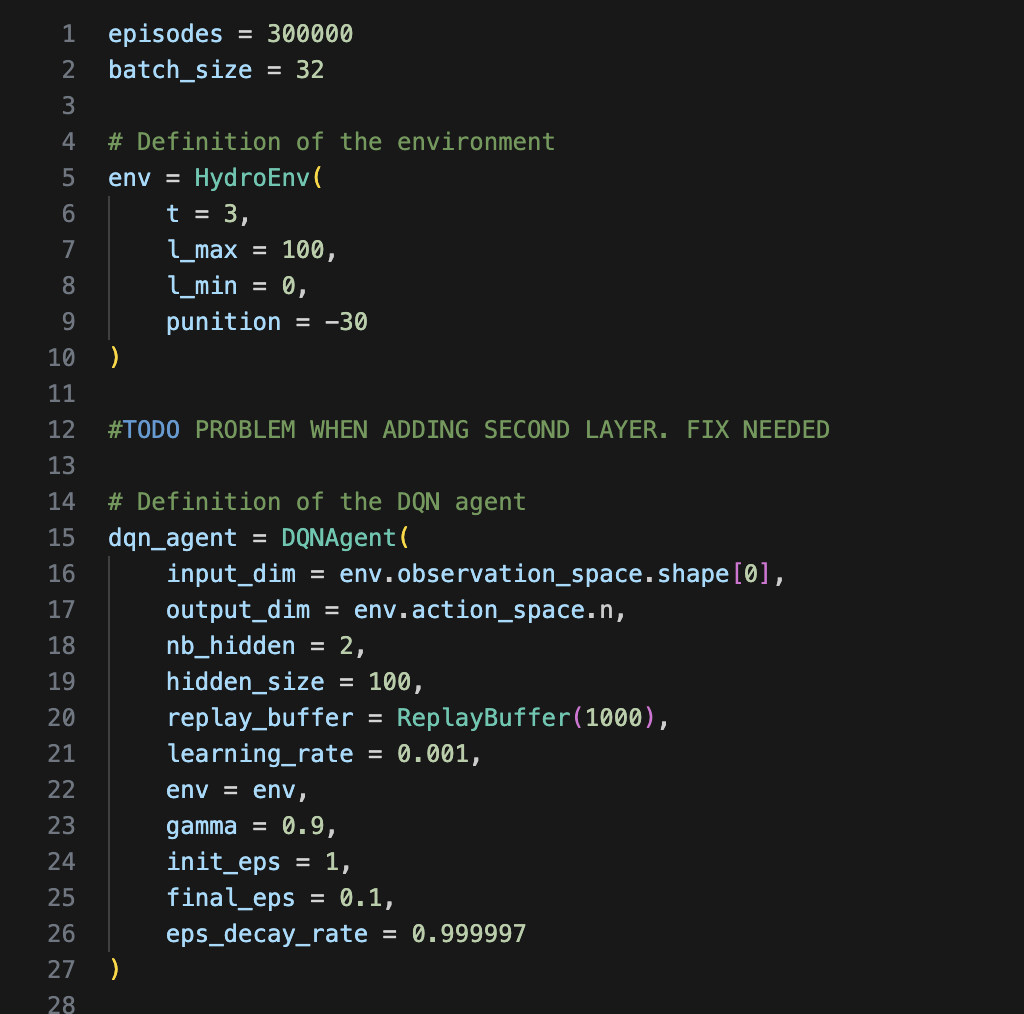

In [3]:
episodes = 300000
batch_size = 60
update_target = 100

# Definition of the environment
env = HydroEnv(
    t = 3,
    l_max = 100,
    l_min = 0,
    punition = -30
)

#TODO PROBLEM WHEN ADDING SECOND LAYER. FIX NEEDED

# Definition of the DQN agent
dqn_agent = DQNAgent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n,
    nb_hidden = 2,
    hidden_size = 100,
    replay_buffer = ReplayBuffer(500),
    learning_rate = 0.0002,
    env = env,
    gamma = 0.9,
    init_eps = 1,
    final_eps = 0.1,
    eps_decay_rate = 0.999997
)

reward_history = []
truncated_history = []
count_truncated = 0
for episode in range(episodes):
    # Reset environment which implies randomly generating a state
    env.reset()
    episode_reward = 0
    dqn_agent.epsilon_decay()
    if episode % update_target == 0:
        dqn_agent.update_target_network()
    
    for t in range(env.t):
        state = env.state
        action = dqn_agent.choose_action(state)
        
        next_state, reward, done, truncated, info = env.step(action)

        dqn_agent.replay_buffer.add(state, action, reward, next_state, done)
        dqn_agent.update(batch_size)

        episode_reward += reward

        if done or truncated:
            if truncated:
                count_truncated += 1
                truncated_history.append(episode)
            break
    
    reward_history.append(episode_reward)

    if episode % 10000 == 0:
        print(f'Episode: {episode}, % of episodes: {episode/episodes * 100} %')
        print(f'epsilon: {round(dqn_agent.eps, 2)}')

print(f'\n\n % of decisions which were eploration: {dqn_agent.exploration_episodes/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
print(f'% of truncated decisions: {count_truncated/(dqn_agent.exploration_episodes + dqn_agent.exploitation_episodes) * 100} %')
dqn_agent.exploitation_episodes = 0
dqn_agent.exploration_episodes = 0

Episode: 0, % of episodes: 0.0 %
epsilon: 1.0
Episode: 10000, % of episodes: 3.3333333333333335 %
epsilon: 0.97
Episode: 20000, % of episodes: 6.666666666666667 %
epsilon: 0.94
Episode: 30000, % of episodes: 10.0 %
epsilon: 0.91
Episode: 40000, % of episodes: 13.333333333333334 %
epsilon: 0.89
Episode: 50000, % of episodes: 16.666666666666664 %
epsilon: 0.86
Episode: 60000, % of episodes: 20.0 %
epsilon: 0.84
Episode: 70000, % of episodes: 23.333333333333332 %
epsilon: 0.81
Episode: 80000, % of episodes: 26.666666666666668 %
epsilon: 0.79
Episode: 90000, % of episodes: 30.0 %
epsilon: 0.76
Episode: 100000, % of episodes: 33.33333333333333 %
epsilon: 0.74
Episode: 110000, % of episodes: 36.666666666666664 %
epsilon: 0.72
Episode: 120000, % of episodes: 40.0 %
epsilon: 0.7
Episode: 130000, % of episodes: 43.333333333333336 %
epsilon: 0.68
Episode: 140000, % of episodes: 46.666666666666664 %
epsilon: 0.66
Episode: 150000, % of episodes: 50.0 %
epsilon: 0.64
Episode: 160000, % of episodes:

In [ ]:
# torch.save(dqn_agent.dqn.state_dict(), '/Users/oli.dmrs/Library/CloudStorage/OneDrive-HECMontréal/StageHEC2025/models/dqn_v1.pth')

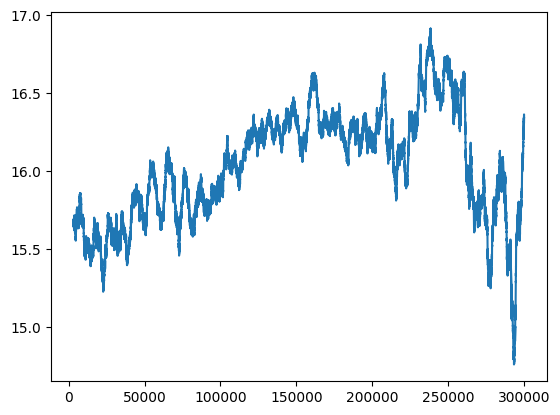

In [4]:
window = 3000
data = np.array(reward_history)
moving_avg = np.convolve(data, np.ones(window)/window, mode='valid')
xticks = [ep for ep in range(episodes)]
plt.plot(xticks[window-1:], moving_avg)

plt.show()

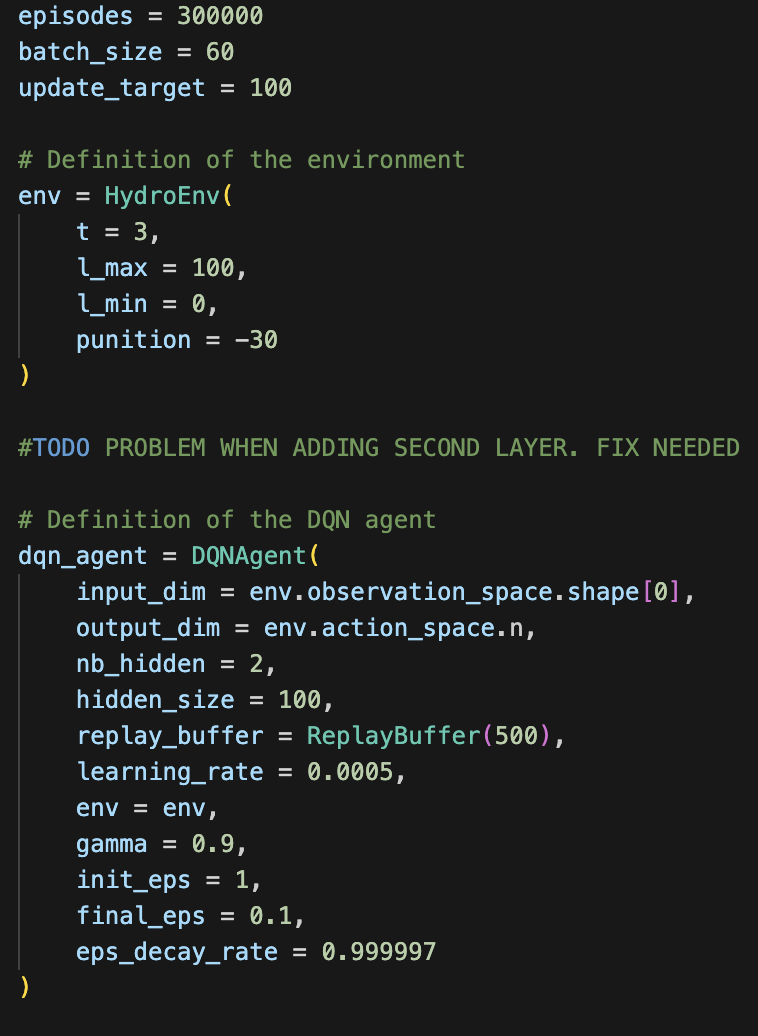